In [1]:
! git clone https://github.com/bemc22/AdaHSI
%cd AdaHSI

fatal: destination path 'AdaHSI' already exists and is not an empty directory.
/content/AdaHSI


In [6]:
#@title Run this cell and then restart runtime
%cd third_party/cython/
!python setup.py install --user
%cd ../..

/content/AdaHSI/third_party/cython
running install
running build
running build_ext
building 'connectivity' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c connectivity.c -o build/temp.linux-x86_64-3.7/connectivity.o
In file included from /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1969:0,
                 from /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from connectivity.c:761:
/usr/local/lib/python3.7/dist-packages/numpy/core/in

In [2]:
#@title Set device
import torch 

if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [3]:
#@title Load model

import os 

m_value = 32   # Amount of SLIC superpixels
s_value = 512  # Amount of deep superpixels
num_channels = 162
dataset  = "wdc"    

model_path = f"model_best_wdc_pretrain_n=512.tar"
model_path = os.path.join("checkpoints", model_path)


from ada_hsi.models import SPCApative
features=[16, 32, 64, 128]

model_name = 'spixelnet'


model_args = dict(
    n_channels= num_channels,
)

if model_name == 'unet':
  model_args['features'] = features


model = SPCApative(model_args, model_name=model_name, concat_sideinfo=True, pos_encod=False, slic=True)
model.load_state_dict(torch.load(model_path, map_location=DEVICE)['state_dict'])


Sideinformation with multiplicative operation


<All keys matched successfully>

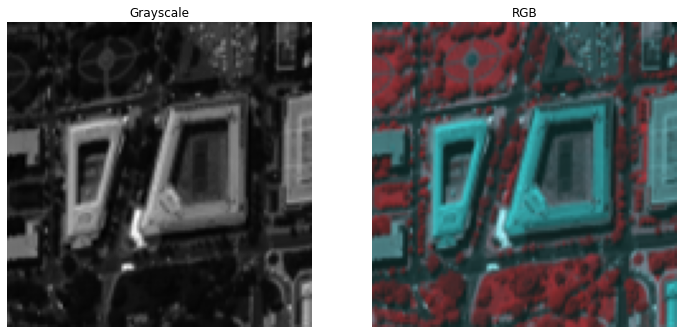

In [5]:
#@title Load and Visualize Data

import scipy.io as sio
import matplotlib.pyplot as plt

RGB = [30, 0, 2]

data_path = "data/patch_9.mat"
data = sio.loadmat(data_path)
grayscale = data['gs'].astype('float32')
infrared  = data['ir'].astype('float32')

fake_rgb = infrared[:, :, RGB]
fake_rgb = fake_rgb / fake_rgb.max()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_ = [ax.axis('off') for ax in axs]

axs[0].imshow(grayscale[..., 0], cmap='gray')
axs[0].set_title('Grayscale')

axs[1].imshow(fake_rgb)
axs[1].set_title('RGB')

plt.show()

In [6]:
#@title Inference

import math
import numpy as np 

from ada_hsi.train import get_decimation_matrix, spc_estimation
from ada_hsi.spixelnet.train_util import init_spixel_grid

SIZE = 120
BATCH_SIZE = 1

downsize = math.ceil(SIZE / np.sqrt(s_value))

args = dict(
    img_height = SIZE,
    img_width =  SIZE,
    batch_size = BATCH_SIZE,
    downsize = downsize,
)


_input = torch.tensor(grayscale).permute(2, 0, 1).unsqueeze(0).float()
ir_t   = torch.tensor(fake_rgb).permute(2, 0, 1).unsqueeze(0).float()


prob = model(_input.to(DEVICE))


spixelID, _ = init_spixel_grid(args)
superpixels = get_decimation_matrix(prob, spixelID)
superpixels = superpixels.cpu().numpy()[0]
superpixels = superpixels.astype(np.int64)
ir_est = spc_estimation(ir_t, prob, spixelID, s_value)
fake_rgb_est = ir_est[0].permute(1, 2, 0).cpu().numpy()

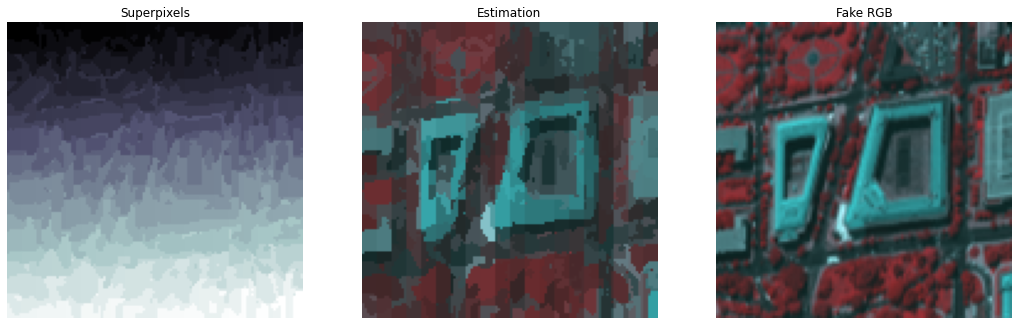

In [7]:
#@title Visualize Results
from skimage.segmentation import mark_boundaries
import cv2

factor = 5
gs_rgb = np.tile(grayscale, (1, 1, 3))
gs_rgb = cv2.resize(gs_rgb, (SIZE*factor, SIZE*factor), interpolation=cv2.INTER_NEAREST)
label = np.kron(superpixels, np.ones((factor, factor))).astype(np.int64)
label  = mark_boundaries(gs_rgb, label)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

_ = [ax.axis('off') for ax in axs]


axs[0].imshow(superpixels, cmap='bone')
axs[0].set_title('Superpixels')

axs[1].imshow(fake_rgb_est)
axs[1].set_title('Estimation')

axs[2].imshow(fake_rgb)
axs[2].set_title('Fake RGB')

plt.show()
